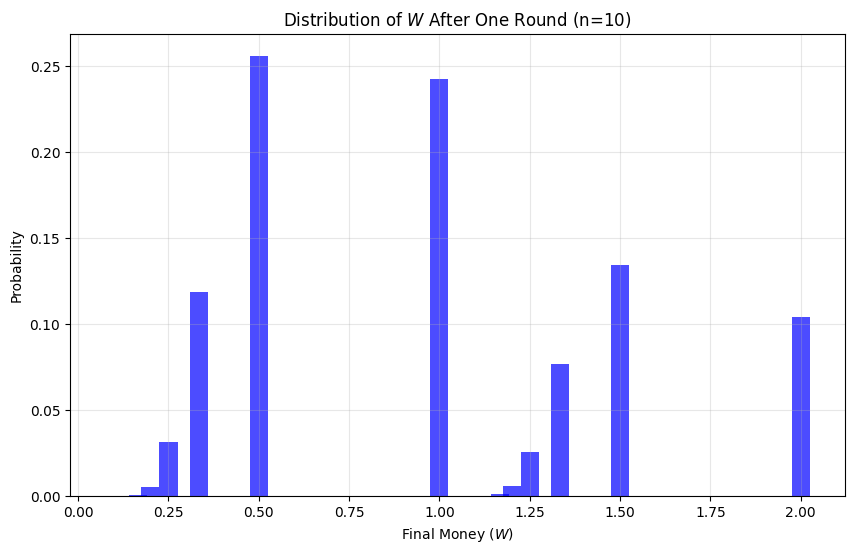

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

# Define the probabilities for X_i given n
def probability_X_i(n):
    # Precompute probabilities
    p_not_robbed = lambda k: comb(n-1, k-1) * (1/(n-1))**(k-1) * ((n-3)/(n-1))**(n-k)
    p_robbed = lambda x, k: comb(n-1, x) * comb(n-1-x, k-1) * (1/(n-1))**(x+k-1) * ((n-3)/(n-1))**(n-1-x-(k-1))
    
    values = []
    probabilities = []
    
    # Compute probabilities for not robbed (1 + 1/k)
    for k in range(1, n+1):
        prob = p_not_robbed(k)
        values.append(1 + 1/k)
        probabilities.append(prob)
    
    # Compute probabilities for robbed (1/k)
    for k in range(1, n+1):
        prob_sum = 0
        for x in range(1, n-k+1):  # Sum over all x where 1 <= x <= n-k
            prob_sum += p_robbed(x, k)
        values.append(1 / k)
        probabilities.append(prob_sum)
    
    return np.array(values), np.array(probabilities)

# Set n and compute probabilities
n = 10  # Choose a manageable size to avoid overflow/underflow
values, probabilities = probability_X_i(n)

# Normalize probabilities (in case of numerical inaccuracies)
probabilities /= probabilities.sum()

# Sort values for better plotting
sorted_indices = np.argsort(values)
values = values[sorted_indices]
probabilities = probabilities[sorted_indices]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(values, probabilities, width=0.05, color="blue", alpha=0.7)
plt.xlabel("Final Money ($W$)")
plt.ylabel("Probability")
plt.title(f"Distribution of $W$ After One Round (n={n})")
plt.grid(True, alpha=0.3)
plt.show()


In [3]:
import pandas as pd
from scipy import stats

# Compute the correct probabilities for each wealth value

# Probability of not being robbed
p_keep = ((n - 2) / (n - 1)) ** (n - 1)

# Probability of being robbed
p_robbed = 1 - p_keep

# Define wealth values
t_values = np.arange(n - 1)
wealth_not_robbed = 1 + 1 / (t_values + 1)
wealth_robbed = 1 / (t_values + 1)

# Compute probabilities for each wealth outcome
prob_not_robbed = p_keep * stats.binom.pmf(t_values, n - 2, 1 / (n - 2))
prob_robbed = p_robbed * stats.binom.pmf(t_values, n - 2, 1 / (n - 1))

# Create a new DataFrame with the correct wealth values and their probabilities
wealth_values = np.concatenate((wealth_not_robbed, wealth_robbed))
probabilities = np.concatenate((prob_not_robbed, prob_robbed))

# Group and sum duplicate wealth values
wealth_distribution_corrected = pd.DataFrame({"Wealth": wealth_values, "Probability": probabilities})
wealth_distribution_corrected = wealth_distribution_corrected.groupby("Wealth", as_index=False).sum()

# Display the corrected wealth distribution
print("Corrected Wealth Distribution")
print(wealth_distribution_corrected)


Corrected Wealth Distribution
      Wealth   Probability
0   0.111111  1.518259e-08
1   0.125000  9.716856e-07
2   0.142857  2.720720e-05
3   0.166667  4.353151e-04
4   0.200000  4.353151e-03
5   0.250000  2.786017e-02
6   0.333333  1.114407e-01
7   0.500000  2.547215e-01
8   1.000000  2.547215e-01
9   1.111111  2.064940e-08
10  1.125000  1.156366e-06
11  1.142857  2.833097e-05
12  1.166667  3.966336e-04
13  1.200000  3.470544e-03
14  1.250000  1.943505e-02
15  1.333333  6.802267e-02
16  1.500000  1.360453e-01
17  2.000000  1.190397e-01


In [4]:
import numpy as np
from scipy.optimize import fsolve
from scipy.special import comb

def compute_optimal_strategy(M, n, verbose=False):
    """
    Computes the symmetric Nash equilibrium strategy for the theft game.

    Parameters:
    - M (list or np.array): Current amounts of money for each player [M1, M2, ..., Mn].
    - n (int): Number of players.
    - verbose (bool): If True, prints additional debug information.

    Returns:
    - sigma_solution (np.array): Optimal strategy probabilities for each player.
    - C_solution (float): Equilibrium expected utility.
    """

    M = np.array(M, dtype=float)
    if len(M) != n:
        raise ValueError("Length of M must be equal to n.")

    def equilibrium_equations(x):
        """
        Defines the system of equations for equilibrium conditions.

        Parameters:
        - x (np.array): Array containing sigma(j) for all j and the constant C.

        Returns:
        - residuals (list): Residuals of the equilibrium equations.
        """
        sigma = x[:n]
        C = x[n]
        residuals = []

        for j in range(n):
            sigma_j = sigma[j]

            # Prevent division by zero or negative probabilities
            if sigma_j <= 0 or sigma_j >= 1:
                residuals.append(1e6)  # Large penalty
                continue

            # Probability of not being targeted by any other player
            prob_not_targeted = (1 - sigma_j)**(n-1)

            # Expected share from targeting player j
            # Simplified using the identity:
            # sum_{k=0}^{n-1} comb(n-1,k) sigma_j^k (1-sigma_j)^(n-1 -k) / (k+1) = [1 - (1 - sigma_j)^n] / (n * sigma_j)
            E_share = (M[j] * (1 - (1 - sigma_j)**n)) / (n * sigma_j)

            # Expected utility when targeting player j
            U_j = prob_not_targeted + E_share

            # Equilibrium condition U(j) = C
            residuals.append(U_j - C)

        # Probability normalization condition: sum_j sigma(j) = 1
        residuals.append(np.sum(sigma) - 1)

        return residuals

    # Initial guess: proportional-to-wealth strategy
    sum_M = np.sum(M)
    if sum_M == 0:
        raise ValueError("Sum of all M_j must be greater than 0.")
    sigma_initial = M / sum_M
    sigma_initial = np.clip(sigma_initial, 1e-6, 1 - 1e-6)  # Avoid exact 0 or 1

    # Initial guess for C using the proportional strategy
    C_initial = np.sum((1 - sigma_initial)**(n-1) + (M * (1 - (1 - sigma_initial)**n)) / (n * sigma_initial))

    # Combine initial guesses into a single array
    x0 = np.concatenate([sigma_initial, [C_initial]])

    # Solve the system of equations using fsolve
    solution, infodict, ier, mesg = fsolve(equilibrium_equations, x0, full_output=True)

    if ier != 1:
        if verbose:
            print("Solution not found:", mesg)
        raise RuntimeError("fsolve did not converge to a solution.")

    sigma_solution = solution[:n]
    C_solution = solution[n]

    # Validate the solution
    if np.any(sigma_solution < 0) or np.any(sigma_solution > 1):
        if verbose:
            print("Invalid solution: Probabilities out of bounds.")
        raise ValueError("Computed probabilities are out of valid range [0, 1].")

    # Normalize to ensure probabilities sum to 1
    sigma_solution /= np.sum(sigma_solution)

    # if verbose:
    #     print("Optimal Strategy (sigma):", sigma_solution)
    #     print("Equilibrium Expected Utility (C):", C_solution)

    return sigma_solution, C_solution


In [5]:
import numpy as np

def compute_optimal_strategy_other(wealths, n):
    """
    Given a list of player wealths, find the self-consistent cutoff c and 
    the probability distribution p.

    :param wealths: list of floats/ints, each representing a player's current wealth.
    :return: (c_star, p), where:
        c_star is the cutoff,
        p is a list of probabilities p_j for j=0..n-1,
            p_j = 0 if x_j <= c_star, 
            else (x_j - c_star)/(c_star*(n-1)).
    """
    indexed_wealths = list(enumerate(wealths))
    # Sort ascending by wealth
    indexed_wealths.sort(key=lambda x: x[1])

    # Prefix sums to help compute sum of top k quickly
    prefix_sum = [0]*(n+1)
    for i in range(1, n+1):
        prefix_sum[i] = prefix_sum[i-1] + indexed_wealths[i-1][1]

    def sum_top_k(k):
        # sum of top k from sorted array (the largest k entries)
        return prefix_sum[n] - prefix_sum[n-k]

    candidates = []

    for k in range(n+1):
        denom = (n - 1 + k)
        if denom <= 0:
            continue
        S_topk = sum_top_k(k)
        if denom != 0:
            c_k = S_topk / denom
        else:
            c_k = 0.0

        # Count how many wealths exceed c_k
        count_above = sum(1 for (_, w) in indexed_wealths if w > c_k)

        # If exactly k of them exceed c_k, it's self-consistent
        if count_above == k:
            candidates.append((k, c_k))

    # If no consistent cutoff is found, return None
    if not candidates:
        return None, None

    # Typically there's a unique solution; pick the first
    k_star, c_star = candidates[0]

    # Now compute p_j in original order
    p = [0.0]*n
    for idx, w in indexed_wealths:
        if w > c_star:
            p[idx] = (w - c_star)/(c_star*(n-1))
        else:
            p[idx] = 0.0

    return np.array(p), c_star

In [6]:
from matplotlib import pyplot as plt

def indices_dict(lst):
    """
    Takes a list and returns a dictionary where the keys are the elements of the list
    and the values are lists of the indices that had that value.
    
    Parameters:
    lst (list): The input list.
    
    Returns:
    dict: A dictionary with elements as keys and lists of indices as values.
    """
    result = {}
    for index, value in enumerate(lst):
        if value not in result:
            result[value] = []
        result[value].append(index)
    return result

# Simulation of the theft game

num_simulations = 500
num_players = 50
num_rounds = 30

results = []

for _ in range(num_simulations):
    Ms = []
    M = np.ones(num_players)
    for r in range(num_rounds):
        M_temp = np.zeros(num_players)
        p_opt, c_opt = compute_optimal_strategy_other(M, num_players)
        
        # Ensure players are not targeted by themselves
        targets = []
        for n in range(num_players):
            self_prob = p_opt[n]
            p_opt[n] = 0
            # Normalize sigma_opt to ensure it sums to 1
            p_opt /= p_opt.sum()
            targets.append(np.random.choice(num_players, p=p_opt))
            p_opt[n] = self_prob
        targets_dict = indices_dict(targets)

        for target, thiefs in targets_dict.items():
            victim_wealth = M[target]
            thief_share = victim_wealth / len(thiefs)
            for thief in thiefs:
                M_temp[thief] += thief_share
            M[target] = 0
        M += M_temp
        Ms.append(M.copy())
    results.append(Ms)

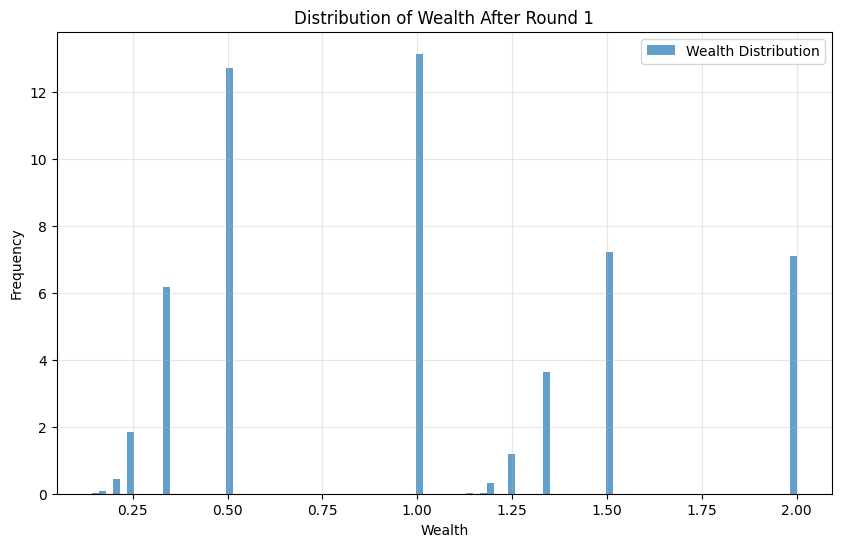

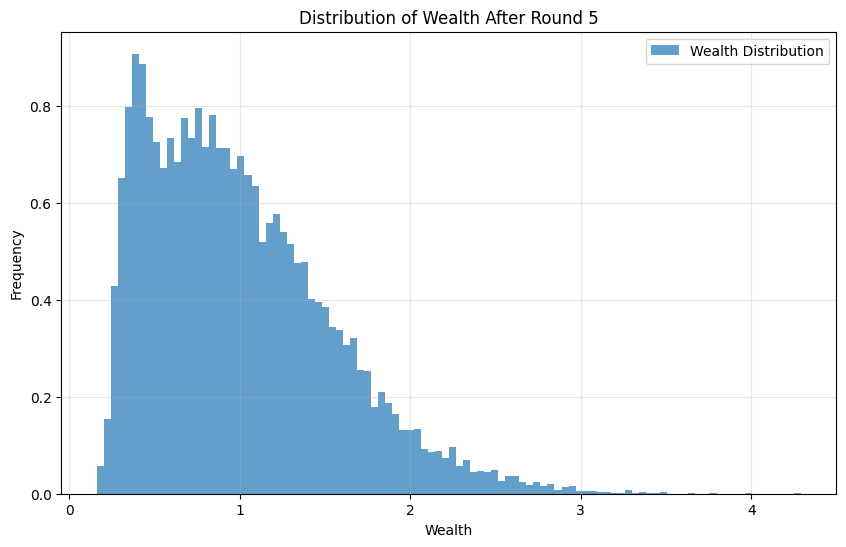

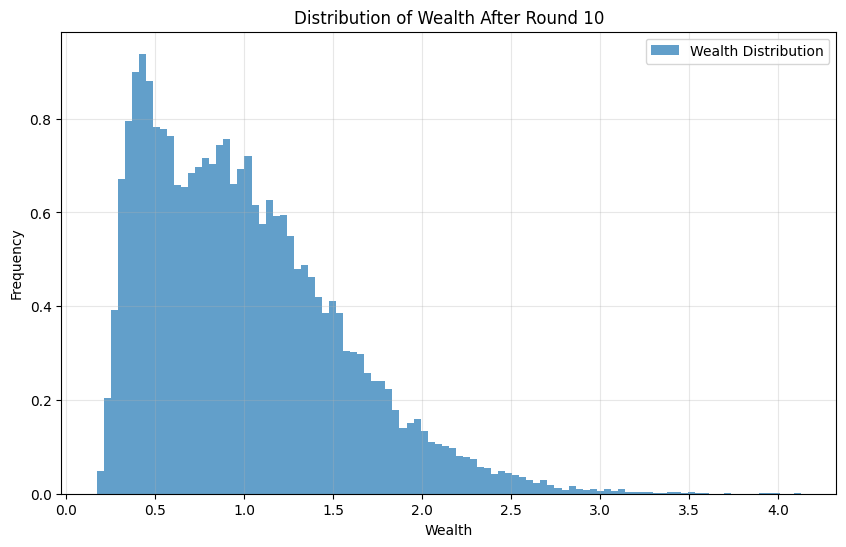

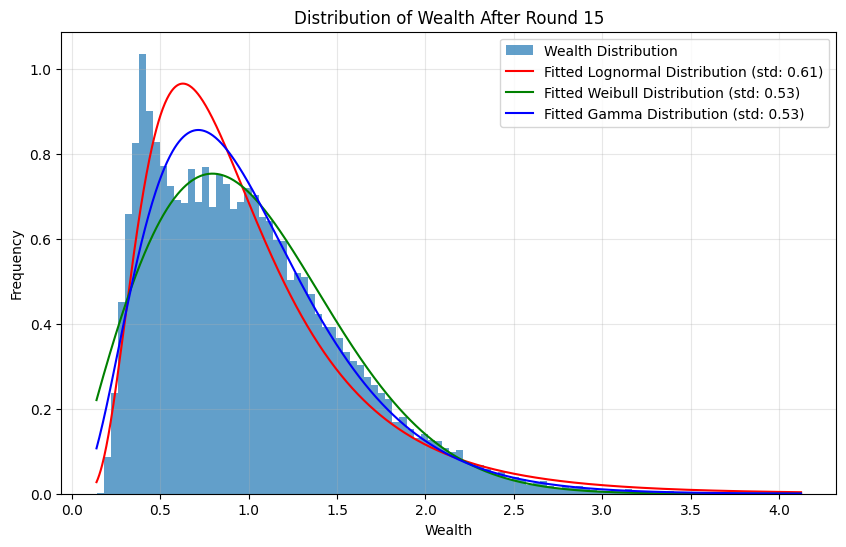

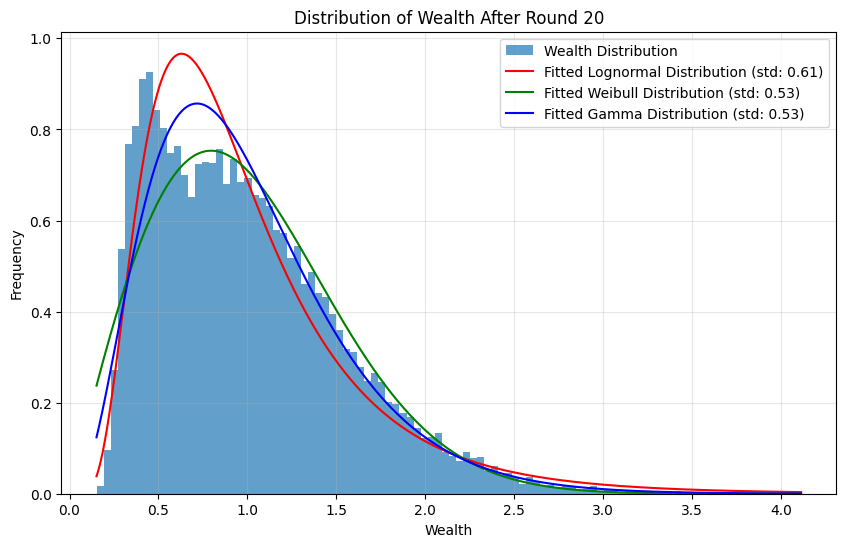

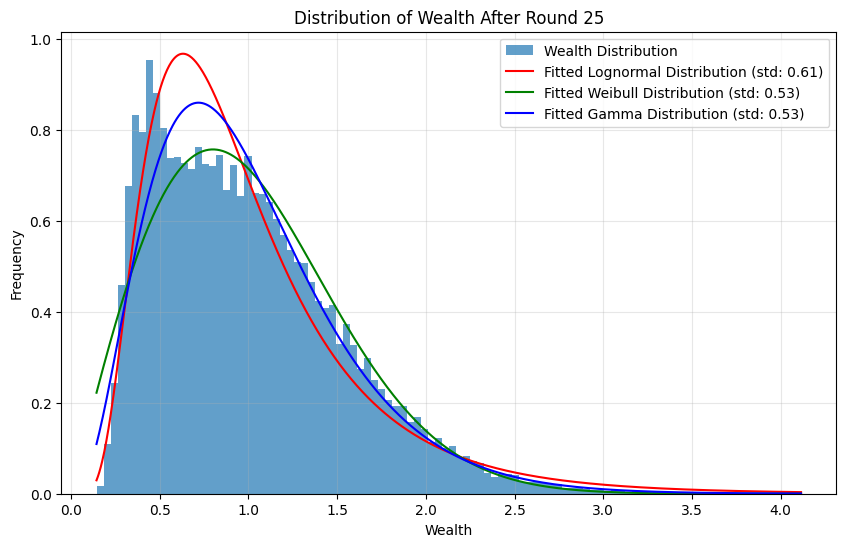

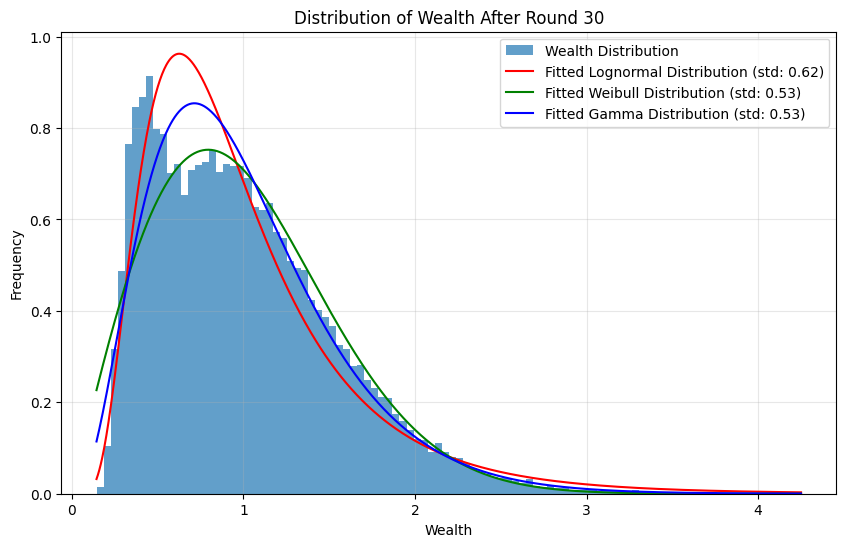

In [7]:
from scipy.stats import lognorm, weibull_min, gamma

# Plot wealth distributions for all rounds and fit lognormal, Weibull, and Gamma distributions to the wealth distributions after round 15
for i in [0] + list(range(4, num_rounds, 5)):
    round_results = [result[i] for result in results]
    round_results = np.array(round_results)
    round_results = round_results.flatten()
    
    plt.figure(figsize=(10, 6))
    plt.hist(round_results, bins=100, alpha=0.7, density=True, label='Wealth Distribution')
    
    if i >= 14:
        # Fit lognormal distribution
        shape, loc, scale = lognorm.fit(round_results, floc=0)
        x = np.linspace(min(round_results), max(round_results), 1000)
        pdf_lognorm = lognorm.pdf(x, shape, loc, scale)
        std_lognorm = lognorm.std(shape, loc, scale)
        plt.plot(x, pdf_lognorm, 'r-', label=f'Fitted Lognormal Distribution (std: {std_lognorm:.2f})')
        
        # Fit Weibull distribution
        c, loc, scale = weibull_min.fit(round_results, floc=0)
        pdf_weibull = weibull_min.pdf(x, c, loc, scale)
        std_weibull = weibull_min.std(c, loc, scale)
        plt.plot(x, pdf_weibull, 'g-', label=f'Fitted Weibull Distribution (std: {std_weibull:.2f})')
        
        # Fit Gamma distribution
        a, loc, scale = gamma.fit(round_results, floc=0)
        pdf_gamma = gamma.pdf(x, a, loc, scale)
        std_gamma = gamma.std(a, loc, scale)
        plt.plot(x, pdf_gamma, 'b-', label=f'Fitted Gamma Distribution (std: {std_gamma:.2f})')
    
    plt.xlabel("Wealth")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Wealth After Round {i+1}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()